Cropping and Rotating

In [1]:
def crop_rotate_dir(input_dir = 'input',output_dir='output', angle = -1.5, left = 135, upper =85, right = 600, lower = 390):
    from PIL import Image
    import os, glob
    # read every image file from the input folder
    for filename in glob.glob(input_dir+'/*.jpg'):
        # print(filename)
        with Image.open(filename) as im:
            # (left, upper, right, lower) = (100, 60, 630, 400)
            rotated = im.rotate(angle, expand = 1)
            im_final = rotated.crop((left, upper, right, lower))            
            im_final.save(filename.replace(input_dir, output_dir))

In [3]:
# Best parameters
crop_rotate_dir(input_dir = 'input',output_dir='output',left = 135, upper =85, right = 600, lower = 390)

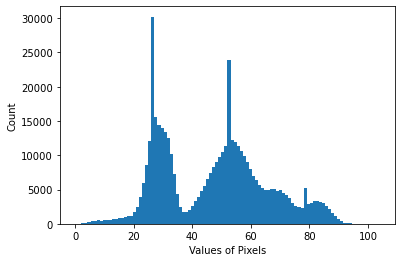

In [52]:
# colmport the necessary libraries
from PIL import Image
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import os, glob

# this is a pipeline that allows you to do an operation on each well for each image
def pipeline(input_dir = 'output'):
    import os, glob
    from PIL import Image
    import numpy as np
    from numpy import asarray
    # read every image file from the input folder
    big_output = []
    pred_outputs = []
    for filename in glob.glob(input_dir+'/*.jpg'):
        img = Image.open(filename).convert('L')
        img_numpydata = asarray(img)
        y = img_numpydata.shape[0] / 16
        x = img_numpydata.shape[1] / 24
        output = np.zeros(shape=(16,24))
        pred_output = np.zeros(shape=(16,24))
        rows = 0
        columns = 0
        for col in np.arange(0, img_numpydata.shape[0], y):
            for row in np.arange(0, img_numpydata.shape[1], x):
                out = img_numpydata[round(col):round(col+y),round(row):round(row+x)]
                std = np.std(out)
                mean = np.mean(out)
                min = np.amin(out)
                output[rows,columns] = min
                pred_output[rows,columns] = 1 if min < mean-4*std else 0
                # pred_output[rows,columns] = 1 if min < 38 else 0
                columns += 1
            rows += 1
            columns = 0
        np.savetxt(filename.replace(input_dir, 'output_values').replace('.jpg','.txt'), output)
        np.savetxt(filename.replace(input_dir, 'output_pred').replace('.jpg','.txt'), pred_output, fmt='%1i')
        pred_outputs.append(pred_output)
        big_output.append(output)
    # plot histogram of output
    plt.xlabel('Values of Pixels')
    plt.ylabel('Count')
    plt.hist(asarray(big_output).flatten(), bins=100)

pipeline()


# Using the new data
This demo below assumes that we have a folder output_pred/ that has a numpy arrays as txt 16x24 as the output of the model for each well. 
It also assumes that we have a data.csv which is the data that Ginko gave us on Oct 27th.

In [36]:
import pandas as pd
import numpy as np
# takes in a numpy array with the predicted labels and csv and outputs metrics 
def verification(pred_filename, df2):
    # get destination_plate_bcode
    destination_plate_bcode = int(pred_filename.split('_')[-1].split('.')[0])
    # read in csv
    df = df2.copy()
    # get the rows which have matching "destination_plate_bcode"
    df3 = df[df['destination_plate_bcode'] == destination_plate_bcode]
    # read destination well of each row
    destination_wells = df3['destination_well'].values

    letters_to_index = {
        "A": 0,
        "B": 1,
        "C": 2,
        "D": 3,
        "E": 4,
        "F": 5,
        "G": 6,
        "H": 7,
        "I": 8,
        "J": 9,
        "K": 10,
        "L": 11,
        "M": 12,
        "N": 13,
        "O": 14,
        "P": 15
    }

    ground_truth = np.zeros(shape=(16,24))
    for destination in destination_wells:
        row = letters_to_index[destination[0]]
        col = int(destination[1:]) - 1
        ground_truth[row, col] = 1
    # print(pd.DataFrame(ground_truth))
    # read in the predicted values
    pred = np.loadtxt(pred_filename)
    # calculate the metrics
    tp = np.sum(np.logical_and(pred == 1, ground_truth == 1))
    tn = np.sum(np.logical_and(pred == 0, ground_truth == 0))
    fp = np.sum(np.logical_and(pred == 1, ground_truth == 0))
    fn = np.sum(np.logical_and(pred == 0, ground_truth == 1))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return precision, recall, f1, accuracy, not df3.empty

# get the average accuracy of all the images
def verification_all_plates(dir="output_pred"):
    import os, glob
    # read every image file from the input folder
    acc = []
    df = pd.read_csv('data.csv')

    for filename in glob.glob(dir+'/*.txt'):
        # print(filename)
        p, r, f1, a, no_ground_truth = verification(filename, df)
        # print(a)
        if no_ground_truth:
            acc.append(a)
    return np.mean(acc), acc

# output = verification_all_plates()
# test
df = pd.read_csv('data.csv')
verification("/Users/JIMENDI1/Documents/ginko/output_pred/220104_150753_862416.txt", df)

(0.449685534591195, 1.0, 0.6203904555314533, 0.5442708333333334, True)

In [ ]:
output = verification_all_plates()

(array([130.,  30.,  13.,  51.,  31.,  29.,  16.,  33.,  23.,  23.,  36.,
         29.,  22.,  46.,  67.,  89., 148., 205., 130.,  60.]),
 array([0.        , 0.04960937, 0.09921875, 0.14882812, 0.1984375 ,
        0.24804688, 0.29765625, 0.34726562, 0.396875  , 0.44648437,
        0.49609375, 0.54570312, 0.5953125 , 0.64492187, 0.69453125,
        0.74414062, 0.79375   , 0.84335937, 0.89296875, 0.94257812,
        0.9921875 ]),
 <BarContainer object of 20 artists>)

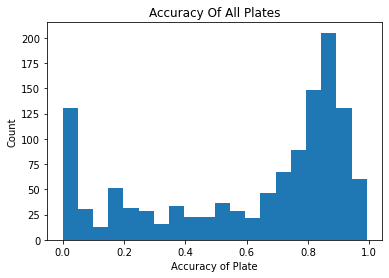

In [54]:
import matplotlib.pyplot as plt
plt.title("Accuracy Of All Plates")
plt.xlabel('Accuracy of Plate')
plt.ylabel('Count')
plt.hist(output[1], bins=20)

In [28]:
pred = np.loadtxt('output_pred/220104_150753_862416.txt')
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
